In [14]:
import numpy as np 
import vstats as vs
from thermodynamics import *
import netCDF4 as nc
import matplotlib.pyplot as plt
import smooth as sm
from file_utils import *
from plot_utils import *
%pylab inline
pylab.rcParams['figure.figsize'] = (8.0, 8.0)

Populating the interactive namespace from numpy and matplotlib


### read in data 

In [15]:
before_path_g = "../data/globalstats/globalstats_fastcloud_"
before_path_v = "../data/verticalstats/verticalstats_fastcloud_"
after2x_path_g = "../data/globalstats/globalstats_fastcloud_2xco2_"
after2x_path_v = "../data/verticalstats/verticalstats_fastcloud_2xco2_"
after4x_path_g = "../data/globalstats/globalstats_fastcloud_4xco2_"
after4x_path_v = "../data/verticalstats/verticalstats_fastcloud_4xco2_"

In [16]:
## make the time variable for the whole pre-doubling equilibration run
before_time = readtime(filepath=before_path_g,nfiles=12,ndays=10.,offset=0.)

## make the time variables for the whole post-doubling runs
after2x_time = readtime(filepath=after2x_path_g,nfiles=3,ndays=10.,offset=before_time[-1])
after4x_time = readtime(filepath=after4x_path_g,nfiles=2,ndays=10.,offset=before_time[-1])
    
# get z dimension
zdim = np.array(nc.Dataset('../data/verticalstats/verticalstats_fastcloud_0.nc').variables['z'])

# create timeseries objects
# convert time to days before or after co2 doubling
before = TimeSeries(time=before_time - max(before_time), z=zdim) 
after2x = TimeSeries(time=after2x_time-after2x_time[0], z=zdim)
after4x = TimeSeries(time=after4x_time-after4x_time[0], z=zdim)

# extract full 1D time series from predoubling run for these variables
variable_names_1d = ['dlsurf', 'Q','swup','Le','Lm']

before.read1d(vars=variable_names_1d,filepath=before_path_g,nfiles=12)
after2x.read1d(vars=variable_names_1d,filepath=after2x_path_g,nfiles=3)
after4x.read1d(vars=variable_names_1d,filepath=after4x_path_g,nfiles=2)

# extract full 2D time series from predoubling run for these variables
variable_names_2d = ['cloud','Q','qv','p','tabs', 'thetae','qc','qi','swdown','swup']

before.read2d(vars=variable_names_2d,filepath=before_path_v,nfiles=12)
after2x.read2d(vars=variable_names_2d,filepath=after2x_path_v,nfiles=3)
after4x.read2d(vars=variable_names_2d,filepath=after4x_path_v,nfiles=2)

### temperature

In [17]:
# use last 30 days of equilibration run as climatology
tabs_mean = vs.profile(before.vars_2d['tabs'],tb=np.where(before.time>-30.)[0][0])
tabs_anom2x = after2x.vars_2d['tabs']-tabs_mean
tabs_anom4x = after4x.vars_2d['tabs']-tabs_mean

(<matplotlib.figure.Figure at 0x108826090>,
 <matplotlib.axes._subplots.AxesSubplot at 0x10e2e8350>)

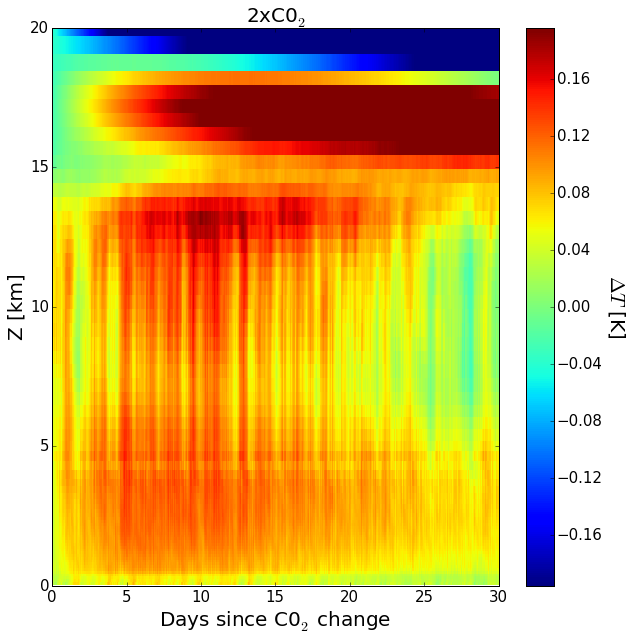

In [18]:
# 2xco2
# set colorbar range based on tropospheric range (stratosphere off scale in this plot)
vmin = -np.max(np.abs([np.min(tabs_anom2x[:,0:56]),np.max(tabs_anom2x[:,0:56])]))
vmax = -vmin
plot_vstats_anom(path='',size=(10,10),title='2xC0$_2$',
                 time=after2x.time,z=after2x.z/1.e3,
                 anom_data=tabs_anom2x,
                 ylim=[0,20],vmin=vmin,vmax=vmax,
                 cbar_label='$\Delta T$ [K]')

(<matplotlib.figure.Figure at 0x1079daed0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x10984d590>)

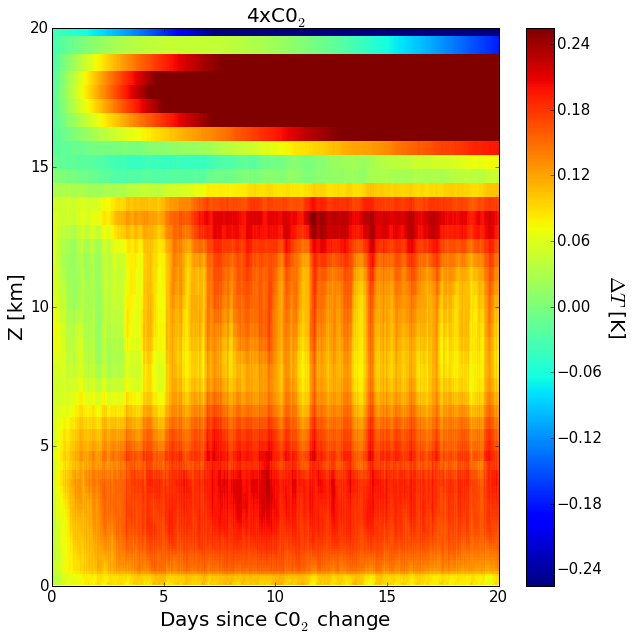

In [19]:
# 4xco2
vmin = -np.max(np.abs([np.min(tabs_anom4x[:,0:56]),np.max(tabs_anom4x[:,0:56])]))
vmax = -vmin
plot_vstats_anom(path='',size=(10,10),title='4xC0$_2$',
                 time=after4x.time,z=after4x.z/1.e3,
                 anom_data=tabs_anom4x,
                 ylim=[0,20],vmin=vmin,vmax=vmax,
                 cbar_label='$\Delta T$ [K]')

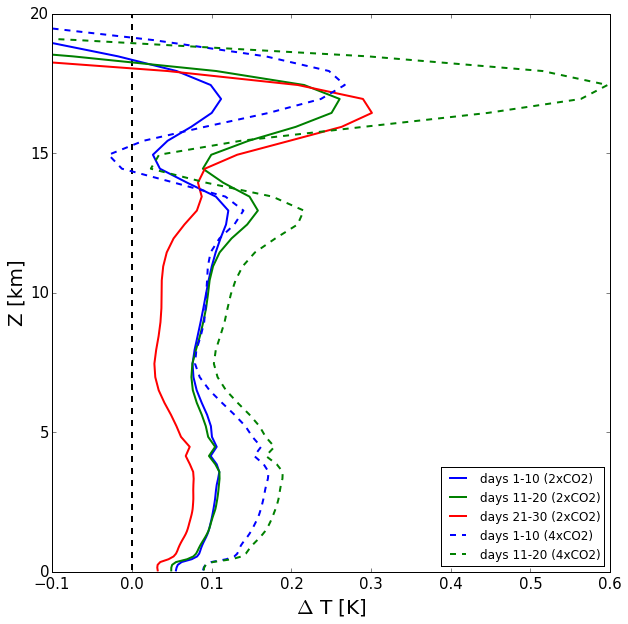

In [20]:
colors = ['blue','green','red']
color_i = 0
fig, ax = plt.subplots(1,figsize=(10,10))
ax.plot([0,0],[before.z[0]/1.e3,before.z[-1]/1.e3],lw=2,color='black',linestyle='--')
for i in np.arange(0,30,10):
    ax.plot(np.mean(after2x.vars_2d['tabs'][(i*48):((i+10)*48),:],axis=0)-tabs_mean,before.z/1.e3,lw=2,
            label='days '+str(i+1)+'-'+str(i+10)+' (2xCO2)',color=colors[color_i])
    color_i = color_i + 1
color_i = 0
for i in np.arange(0,20,10):
    ax.plot(np.mean(after4x.vars_2d['tabs'][(i*48):((i+10)*48),:],axis=0)-tabs_mean,before.z/1.e3,lw=2,
            label='days '+str(i+1)+'-'+str(i+10)+' (4xCO2)',color=colors[color_i],linestyle='--')
    color_i = color_i + 1
ax.set_xlim([-0.1,.6])
ax.set_ylim([0,20])
ax.set_xlabel('$\Delta$ T [K]',size=20)
ax.set_ylabel('Z [km]',size=20)
ax.tick_params(axis='x',labelsize=15)
ax.tick_params(axis='y',labelsize=15)
ax.legend(loc=4)

### water vapor 

In [21]:
qv_mean = vs.profile(before.vars_2d['qv'],tb=np.where(before.time>-30.)[0][0])
qv_anom2x = after2x.vars_2d['qv']-qv_mean
qv_anom4x = after4x.vars_2d['qv']-qv_mean

(<matplotlib.figure.Figure at 0x10f96d210>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1079aded0>)

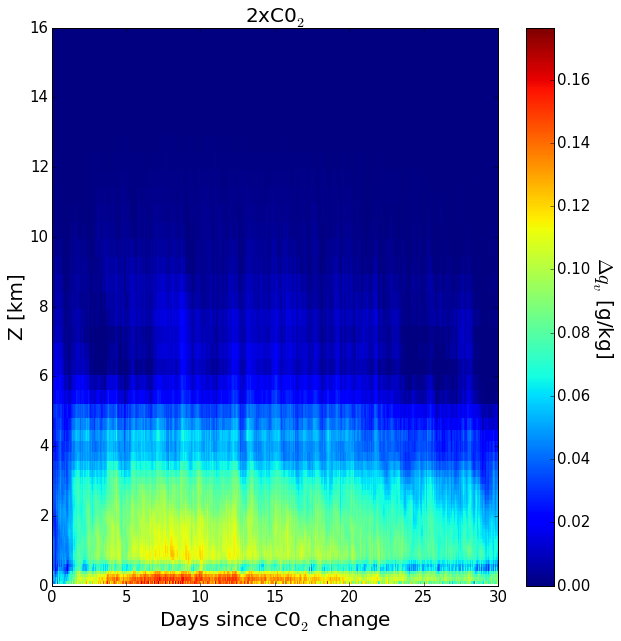

In [22]:
# 2xco2
vmin = 0.
vmax = 1.e3*np.max(qv_anom2x)
plot_vstats_anom(path='',size=(10,10),title='2xC0$_2$',
                 time=after2x.time,z=after2x.z/1.e3,
                 anom_data=1.e3*qv_anom2x,
                 ylim=[0,16],vmin=vmin,vmax=vmax,
                 cbar_label='$\Delta q_v$ [g/kg]')

(<matplotlib.figure.Figure at 0x109800c50>,
 <matplotlib.axes._subplots.AxesSubplot at 0x10980b410>)

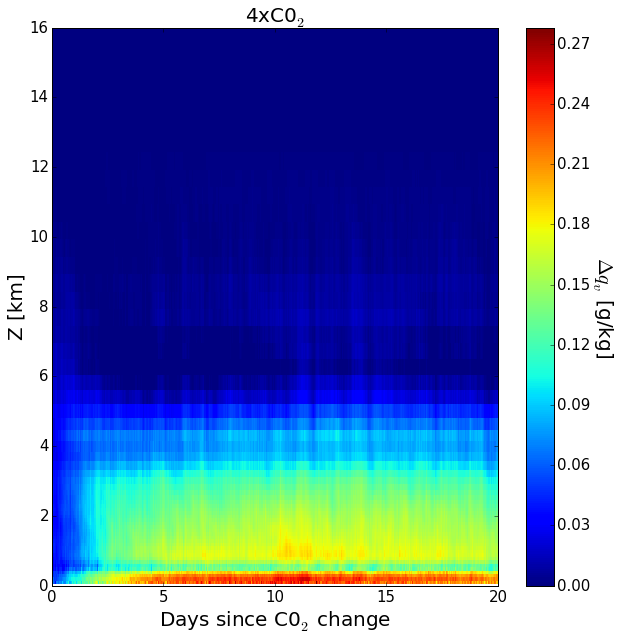

In [23]:
# 4xco2
vmin = 0.
vmax = 1.e3*np.max(qv_anom4x)
plot_vstats_anom(path='',size=(10,10),title='4xC0$_2$',
                 time=after4x.time,z=after2x.z/1.e3,
                 anom_data=1.e3*qv_anom4x,
                 ylim=[0,16],vmin=vmin,vmax=vmax,
                 cbar_label='$\Delta q_v$ [g/kg]')

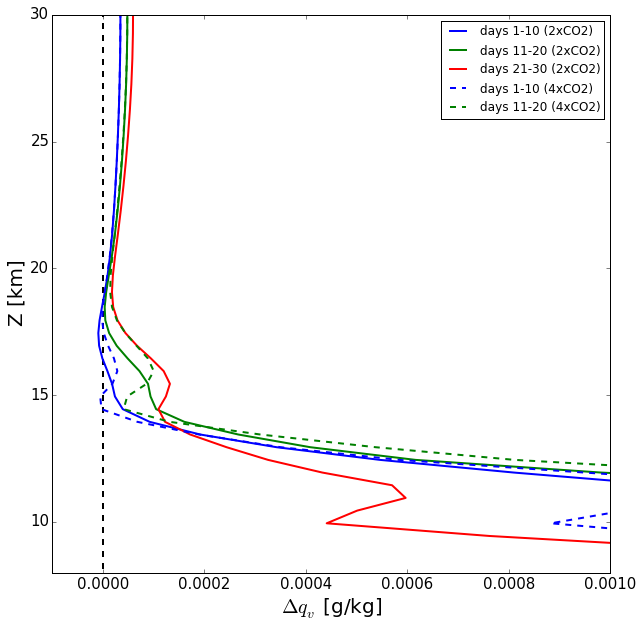

In [24]:
colors = ['blue','green','red']
color_i = 0
fig, ax = plt.subplots(1,figsize=(10,10))
ax.plot([0,0],[before.z[0]/1.e3,before.z[-1]/1.e3],lw=2,color='black',linestyle='--')
for i in np.arange(0,30,10):
    ax.plot(1.e3*(np.mean(after2x.vars_2d['qv'][(i*48):((i+10)*48),:],axis=0)-qv_mean),before.z/1.e3,lw=2,
            label='days '+str(i+1)+'-'+str(i+10)+' (2xCO2)',color=colors[color_i])
    color_i = color_i + 1
color_i = 0
for i in np.arange(0,20,10):
    ax.plot(1.e3*(np.mean(after4x.vars_2d['qv'][(i*48):((i+10)*48),:],axis=0)-qv_mean),before.z/1.e3,lw=2,
            label='days '+str(i+1)+'-'+str(i+10)+' (4xCO2)',color=colors[color_i],linestyle='--')
    color_i = color_i + 1
ax.set_xlim([-1.e-4,1.e-3])
ax.set_ylim([8,30])
ax.set_xlabel('$\Delta q_v$ [g/kg]',size=20)
ax.set_ylabel('Z [km]',size=20)
ax.tick_params(axis='x',labelsize=15)
ax.tick_params(axis='y',labelsize=15)
ax.legend(loc=1)

### relative humidity

In [35]:
before.RH = before.vars_2d['qv']/qvstar(p=before.vars_2d['p'],T=before.vars_2d['tabs'])
after2x.RH = after2x.vars_2d['qv']/qvstar(p=after2x.vars_2d['p'],T=after2x.vars_2d['tabs'])
after4x.RH = after4x.vars_2d['qv']/qvstar(p=after4x.vars_2d['p'],T=after4x.vars_2d['tabs'])

RH_mean = vs.profile(before.RH,tb=np.where(before.time>-30.)[0][0])
RH_anom2x = after2x.RH - RH_mean 
RH_anom4x = after4x.RH - RH_mean

(<matplotlib.figure.Figure at 0x115805cd0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x11753cdd0>)

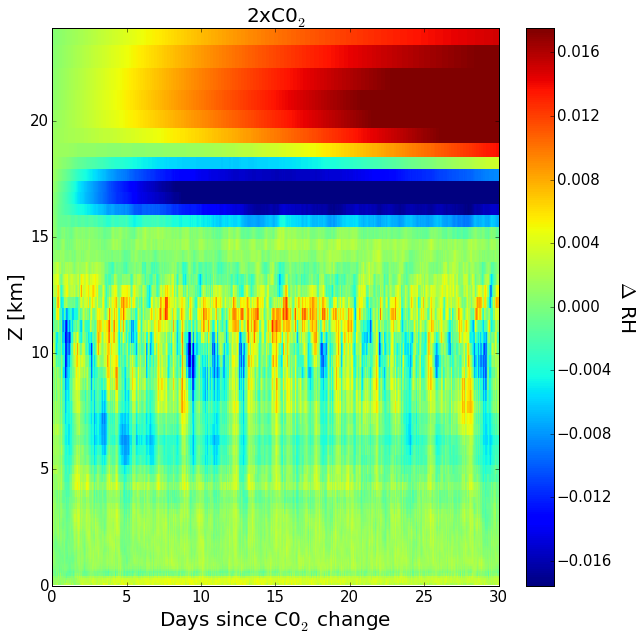

In [39]:
# 2xco2
vmin = -np.max(np.abs([np.min(RH_anom2x[:,0:56]),np.max(RH_anom2x[:,0:56])]))
vmax = -vmin

plot_vstats_anom(path='',size=(10,10),title='2xC0$_2$',
                 time=after2x.time,z=after2x.z/1.e3,
                 anom_data=RH_anom2x,
                 ylim=[0,24],vmin=vmin,vmax=vmax,
                 cbar_label='$\Delta$ RH')

(<matplotlib.figure.Figure at 0x1185945d0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1172caad0>)

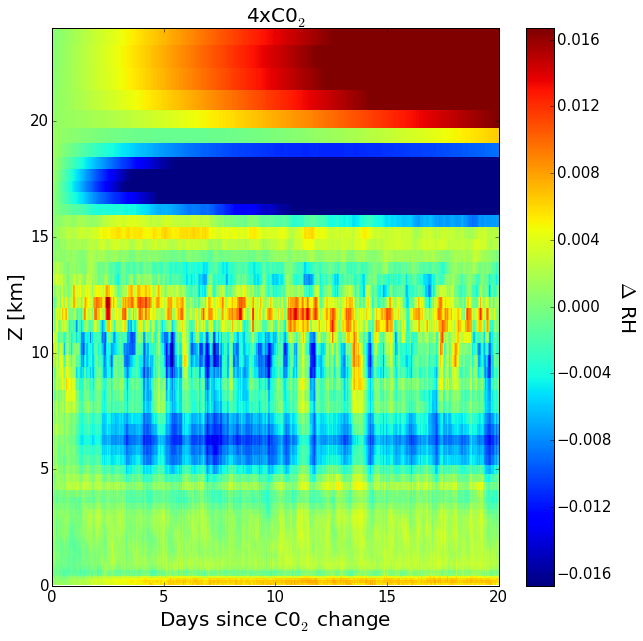

In [46]:
# 4xco2
vmin = -np.max(np.abs([np.min(RH_anom4x[:,0:56]),np.max(RH_anom4x[:,0:56])]))
vmax = -vmin
plot_vstats_anom(path='',size=(10,10),title='4xC0$_2$',
                 time=after4x.time,z=after2x.z/1.e3,
                 anom_data=RH_anom4x,
                 ylim=[0,24],vmin=vmin,vmax=vmax,
                 cbar_label='$\Delta$ RH')

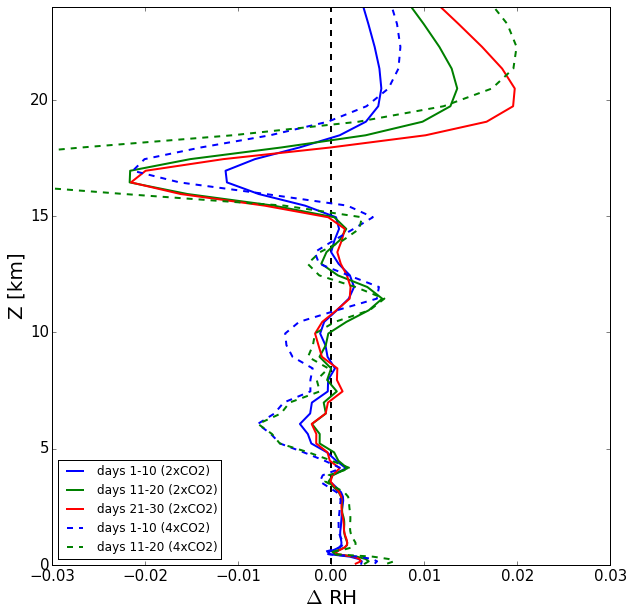

In [44]:
colors = ['blue','green','red']
color_i = 0
fig, ax = plt.subplots(1,figsize=(10,10))
ax.plot([0,0],[before.z[0]/1.e3,before.z[-1]/1.e3],lw=2,color='black',linestyle='--')
for i in np.arange(0,30,10):
    ax.plot(np.mean(after2x.RH[(i*48):((i+10)*48),:],axis=0)-RH_mean,before.z/1.e3,lw=2,
            label='days '+str(i+1)+'-'+str(i+10)+' (2xCO2)',color=colors[color_i])
    color_i = color_i + 1
color_i = 0
for i in np.arange(0,20,10):
    ax.plot(np.mean(after4x.RH[(i*48):((i+10)*48),:],axis=0)-RH_mean,before.z/1.e3,lw=2,
            label='days '+str(i+1)+'-'+str(i+10)+' (4xCO2)',color=colors[color_i],linestyle='--')
    color_i = color_i + 1
ax.set_xlim([-0.03,.03])
ax.set_ylim([0,24])
ax.set_xlabel('$\Delta$ RH',size=20)
ax.set_ylabel('Z [km]',size=20)
ax.tick_params(axis='x',labelsize=15)
ax.tick_params(axis='y',labelsize=15)
ax.legend(loc=3)

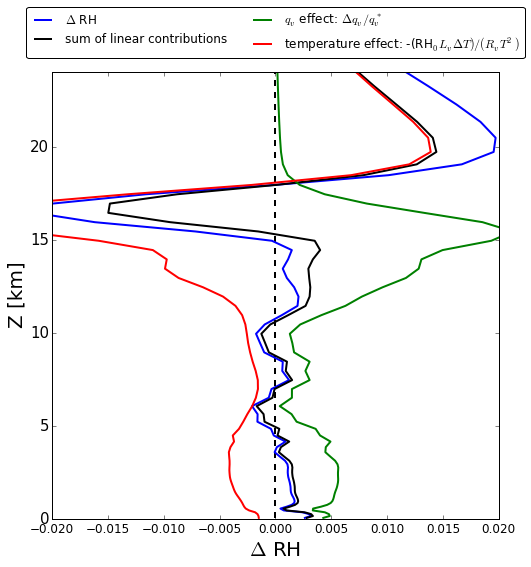

In [45]:
fig, ax = plt.subplots(1)

p_mean = vs.profile(before.vars_2d['p'],tb = np.where(before.time>-30.)[0][0])
after2x.p_mean = vs.profile(after2x.vars_2d['p'],tb = np.where(after2x.time>20.)[0][0])
qvstar_mean = qvstar(p_mean,tabs_mean)

after2x.qv_mean = vs.profile(after2x.vars_2d['qv'],tb = np.where(after2x.time>20.)[0][0])
after2x.tabs_mean = vs.profile(after2x.vars_2d['tabs'],tb = np.where(after2x.time>20.)[0][0])
after2x.RH_mean = vs.profile(after2x.RH,tb = np.where(after2x.time>20.)[0][0])

qv_part =(after2x.qv_mean-qv_mean)/qvstar_mean
T_part = -RH_mean*((L_v/(R_v*tabs_mean**2))*(after2x.tabs_mean-tabs_mean))
ax.plot([0,0],[before.z[0]/1.e3,before.z[-1]/1.e3],lw=2,color='black',linestyle='--')
ax.plot(after2x.RH_mean-RH_mean,before.z/1.e3,lw=2,label='$\Delta$ RH')
ax.plot(qv_part+T_part,before.z/1.e3,lw=2,color='black',label='sum of linear contributions')
ax.plot(qv_part,before.z/1.e3,lw=2,label='$q_v$ effect: $\Delta q_v/q_v^*$')
ax.plot(T_part,before.z/1.e3,lw=2,label='temperature effect: -(RH$_0 L_v \Delta T)/(R_v T^2)$')
#ax.set_xlim([-0.0075,.0075])
ax.set_ylim([0,24])
ax.set_xlim([-.02,.02])
ax.set_xlabel('$\Delta$ RH',size=20)
ax.set_ylabel('Z [km]',size=20)
ax.tick_params(axis='x',labelsize=12)
ax.tick_params(axis='y',labelsize=15)
ax.legend(loc='upper center', bbox_to_anchor=(.5, 1.16),
          ncol=2, fancybox=True, shadow=False)

#fig.savefig('figures/deltaRH_contributions.png', bbox_inches = 'tight', pad_inches=0.5)

### precipitation

In [106]:
before.precip = -86400.*before.vars_1d['dlsurf']
after2x.precip = -86400.*after2x.vars_1d['dlsurf']
after4x.precip = -86400.*after4x.vars_1d['dlsurf']

In [107]:
# smooth 'after' time series to match the time step from before 
ratio = (before.time[-1]-before.time[-2])/(after2x.time[1] - after2x.time[0])

In [108]:
before.time_smooth = sm.smooth(before.time,window_len = 16)
before.precip_smooth =  sm.smooth(before.precip,window_len = 16)

after2x.time_smooth = sm.smooth(after2x.time,window_len = 16*int(ratio))
after2x.precip_smooth =  sm.smooth(after2x.precip,window_len = 16*int(ratio))

after4x.time_smooth = sm.smooth(after4x.time,window_len = 16*int(ratio))
after4x.precip_smooth =  sm.smooth(after4x.precip,window_len = 16*int(ratio))

(-60, 30)

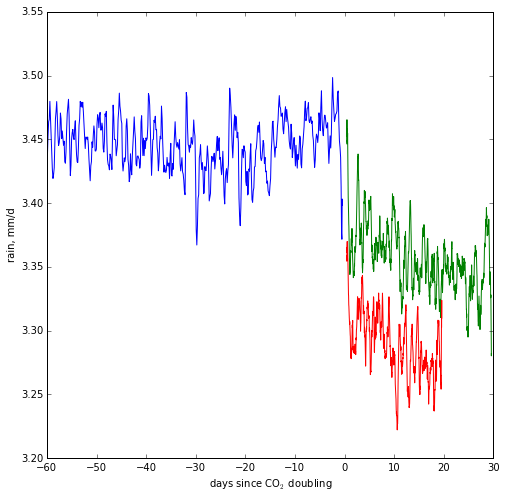

In [109]:
fig, ax = plt.subplots(1)
ax.plot(before.time_smooth, before.precip_smooth)
ax.plot(after2x.time_smooth, after2x.precip_smooth)
ax.plot(after4x.time_smooth, after4x.precip_smooth)
ax.set_xlabel('days since CO$_2$ doubling')
ax.set_ylabel('rain, mm/d')
ax.set_xlim(-60,30)
#fig.savefig('figures/precipitation_2xco2.pdf', bbox_inches = 0)

### Radiative Cooling

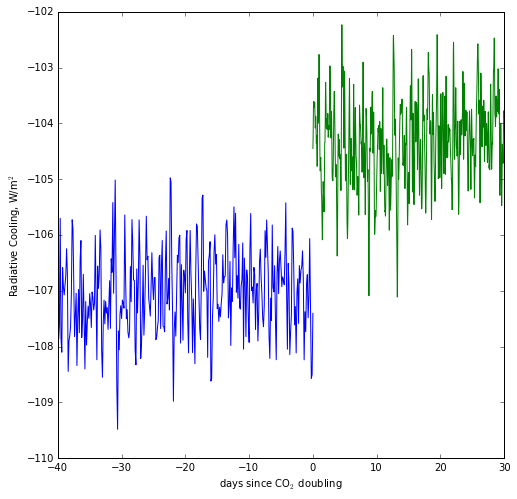

In [43]:
before.Q = before.variables_1d['Q']
after.Q = after.variables_1d['Q']
fig, ax = plt.subplots(1)
after.Q_smooth =  sm.smooth(after.Q,window_len = int(ratio))
ax.plot(before.time, before.Q)
ax.plot(after.time, after.Q_smooth)
ax.plot
ax.set_xlabel('days since CO$_2$ doubling')
ax.set_ylabel('Radiative Cooling, W/m$^2$')
ax.set_xlim(-40,30)
fig.savefig('figures/rad_cooling_2xco2.pdf', bbox_inches = 0)

### swdown

In [105]:
before.swdown = before.variables_2d['swdown']
after.swdown = after.variables_2d['swdown']

before.swup = before.variables_2d['swup']
after.swup = after.variables_2d['swup']

In [108]:
climo_down = profile(before.swdown, tb = np.where(before.time>-80.)[0][0])# use only last 80 days of pre-doubling run
after.swdown_anom = np.zeros(after.swdown.shape)
for i in range(after.swdown.shape[0]): 
    after.swdown_anom[i,:] = after.swdown[i,:] - climo_down
    
climo_up = profile(before.swup, tb = np.where(before.time>-80.)[0][0])# use only last 80 days of pre-doubling run
after.swup_anom = np.zeros(after.swup.shape)
for i in range(after.swup.shape[0]): 
    after.swup_anom[i,:] = after.swup[i,:] - climo_up

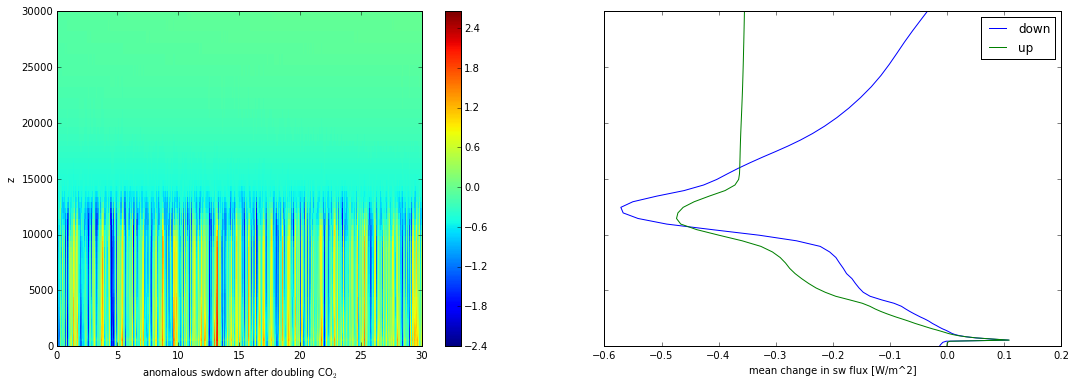

In [111]:
fig, (ax1,ax2) = plt.subplots(1, 2, sharey =True, figsize = (18,6))
im = ax1.pcolormesh(after.time, after.z, after.swdown_anom.transpose())
ax1.set_ylim(0,30000)
fig.colorbar(im , ax = ax1) 
ax2.plot(profile(after.swdown)-profile(before.swdown, tb = np.where(before.time>-80.)[0][0]),before.z,label='down')
ax2.plot(profile(after.swup)-profile(before.swup, tb = np.where(before.time>-80.)[0][0]),before.z,label='up')
ax2.set_xlabel('mean change in sw flux [W/m^2]')
ax1.set_xlabel('anomalous swdown after doubling CO$_2$')
ax1.set_ylabel('z')
plt.legend()
#fig.savefig('figures/cloudfraction_2xco2.png', bbox_inches = 0)

### Clouds

In [39]:
before_cloud = profile(before.vars_2d['cloud'], tb = np.where(before.time>-80.)[0][0])# use only last 80 days of pre-doubling run
after2x_cloud = profile(after2x.vars_2d['cloud'], tb = np.where(after2x.time>20.)[0][0])
after4x_cloud = profile(after4x.vars_2d['cloud'], tb = np.where(after4x.time>0.)[0][0])

before_qc = profile(before.vars_2d['qc'], tb = np.where(before.time>-80.)[0][0])# use only last 80 days of pre-doubling run
after2x_qc = profile(after2x.vars_2d['qc'], tb = np.where(after2x.time>20.)[0][0])
after4x_qc = profile(after4x.vars_2d['qc'], tb = np.where(after4x.time>0.)[0][0])

before_qi = profile(before.vars_2d['qi'], tb = np.where(before.time>-80.)[0][0])# use only last 80 days of pre-doubling run
after2x_qi = profile(after2x.vars_2d['qi'], tb = np.where(after2x.time>20.)[0][0])
after4x_qi = profile(after4x.vars_2d['qi'], tb = np.where(after4x.time>0.)[0][0])

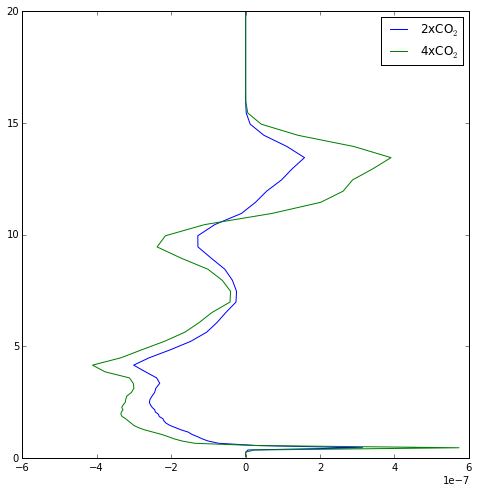

In [41]:
plt.plot((after2x_qc+after2x_qi)-(before_qc+before_qi),before.z/1.e3,label='2xCO$_2$')
plt.plot((after4x_qc+after4x_qi)-(before_qc+before_qi),before.z/1.e3,label='4xCO$_2$')
plt.ylim([0,20])
plt.legend()

/Users/JakeSeeley/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: RuntimeWarning: invalid value encountered in divide
  if __name__ == '__main__':
/Users/JakeSeeley/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:2: RuntimeWarning: invalid value encountered in divide
  from IPython.kernel.zmq import kernelapp as app


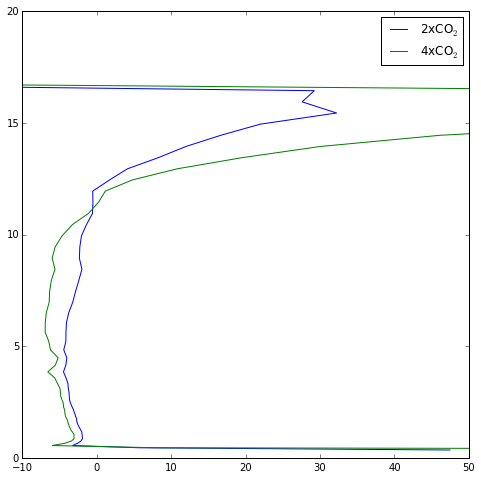

In [53]:
plt.plot(100*(after2x_cloud-before_cloud)/before_cloud,before.z/1.e3,label='2xCO$_2$')
plt.plot(100*(after4x_cloud-before_cloud)/before_cloud,before.z/1.e3,label='4xCO$_2$')
plt.ylim([0,20])
plt.xlim([-10,50])
plt.legend()

(0, 16)

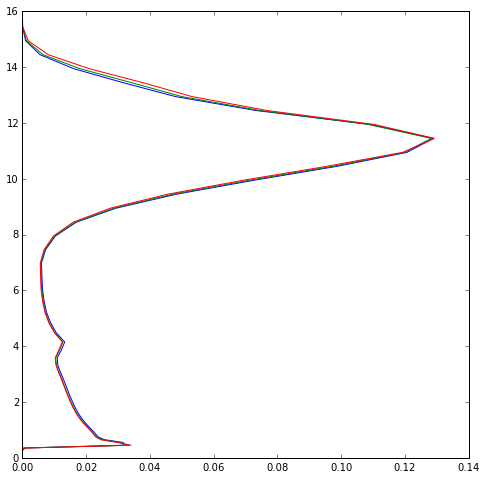

In [38]:
plt.plot(before_cloud,before.z/1.e3)
plt.plot(after2x_cloud,before.z/1.e3)
plt.plot(after4x_cloud,before.z/1.e3)
plt.ylim([0,16])

In [20]:
fig, ax = plt.subplots(1)
after.Q_smooth =  sm.smooth(after.Q,window_len = int(ratio))
ax.plot(before.time, before.Q)
ax.plot(after.time, after.Q_smooth)
ax.plot
ax.set_xlabel('days since CO$_2$ doubling')
ax.set_ylabel('Radiative Cooling, W/m$^2$')
ax.set_xlim(-40,30)

In [73]:
cloud_mean = profile(before.cloud, tb = np.where(before.time>-80.)[0][0])# use only last 80 days of pre-doubling run
after2x.cloud_anom = np.zeros(after.cloud.shape)
for i in range(after.cloud.shape[0]): 
    after.cloud_anom[i,:] = after.cloud[i,:] - climo

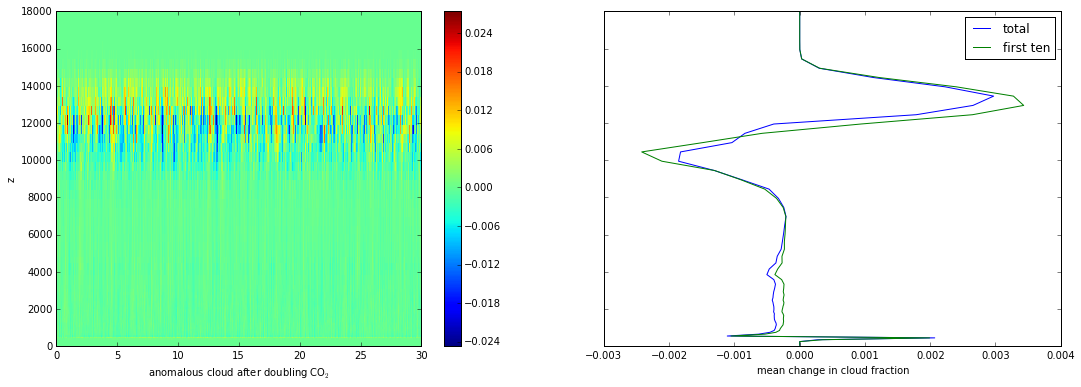

In [91]:
fig, (ax1,ax2) = plt.subplots(1, 2, sharey =True, figsize = (18,6))
im = ax1.pcolormesh(after.time, after.z, after.cloud_anom.transpose())
ax1.set_ylim(0,18000)
fig.colorbar(im , ax = ax1) 
ax2.plot(profile(after.cloud)-profile(before.cloud, tb = np.where(before.time>-80.)[0][0]),before.z,label='total')
ax2.plot(profile(after.cloud, tb = 0,te=np.where(after.time>10.)[0][0])-profile(before.cloud, tb = np.where(before.time>-80.)[0][0]),before.z,label='first ten')
#ax2.plot(profile(after.cloud, tb = np.where(after.time>20.)[0][0])-profile(before.cloud, tb = np.where(before.time>-80.)[0][0]),before.z,label='last ten')
ax2.set_xlabel('mean change in cloud fraction')
ax1.set_xlabel('anomalous cloud after doubling CO$_2$')
ax1.set_ylabel('z')
plt.legend()
#fig.savefig('figures/cloudfraction_2xco2.png', bbox_inches = 0)

### $\theta_e$

In [15]:
after.thetae = getvar('thetae',vstats_after)
before.thetae = variables_2d['thetae']

In [17]:
climo = profile(before.thetae, tb = np.where(before.time>-80.)[0][0])# use only last 80 days of pre-doubling run
after.thetae_anom = np.zeros(after.thetae.shape)
for i in range(after.thetae.shape[0]): 
    after.thetae_anom[i,:] = after.thetae[i,:] - climo

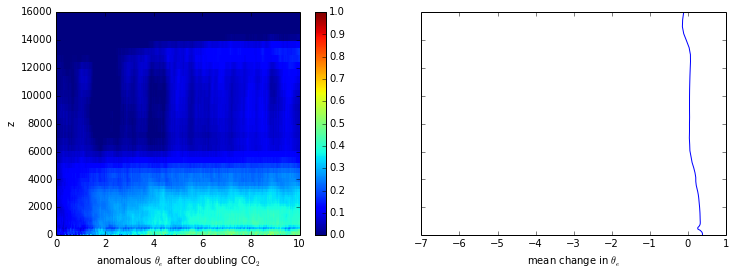

In [27]:
fig, (ax1,ax2) = plt.subplots(1, 2, sharey =True, figsize = (12,4))
im = ax1.pcolormesh(after.time, after.z, after.thetae_anom.transpose(), vmin = 0, vmax = 1)
ax1.set_ylim(0,16000)
fig.colorbar(im , ax = ax1) 
ax2.plot(profile(after.thetae)-profile(before.thetae, tb = np.where(before.time>-80.)[0][0]),before.z)
ax2.set_xlabel('mean change in $\\theta_e$')
ax1.set_xlabel('anomalous $\\theta_e$ after doubling CO$_2$')
ax1.set_ylabel('z')
fig.savefig('figures/thetae_2xco2.png', bbox_inches = 0)

### $q_c$, $q_i$

In [75]:
before.qc = before.variables_2d['qc']
after.qc = after.variables_2d['qc']

before.qi = before.variables_2d['qi']
after.qi = after.variables_2d['qi']

In [77]:
climo_c = profile(before.qc, tb = np.where(before.time>-80.)[0][0])# use only last 80 days of pre-doubling run
climo_i = profile(before.qi, tb = np.where(before.time>-80.)[0][0])# use only last 80 days of pre-doubling run

after.qc_anom = np.zeros(after.qc.shape)
after.qi_anom = np.zeros(after.qc.shape)
for i in range(after.qc.shape[0]): 
    after.qc_anom[i,:] = after.qc[i,:] - climo_c
    after.qi_anom[i,:] = after.qi[i,:] - climo_i

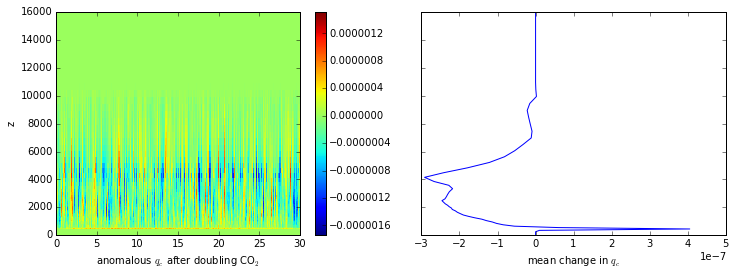

In [78]:
fig, (ax1,ax2) = plt.subplots(1, 2, sharey =True, figsize = (12,4))
im = ax1.pcolormesh(after.time, after.z, after.qc_anom.transpose())
ax1.set_ylim(0,16000)
fig.colorbar(im , ax = ax1) 
ax2.plot(profile(after.qc,tb = np.where(after.time>5.)[0][0])-profile(before.variables_2d['qc'], tb = np.where(before.time>-80.)[0][0]),before.z)
ax2.set_xlabel('mean change in $q_c$')
ax1.set_xlabel('anomalous $q_c$ after doubling CO$_2$')
ax1.set_ylabel('z')
fig.savefig('figures/qc_2xco2.png', bbox_inches = 0)

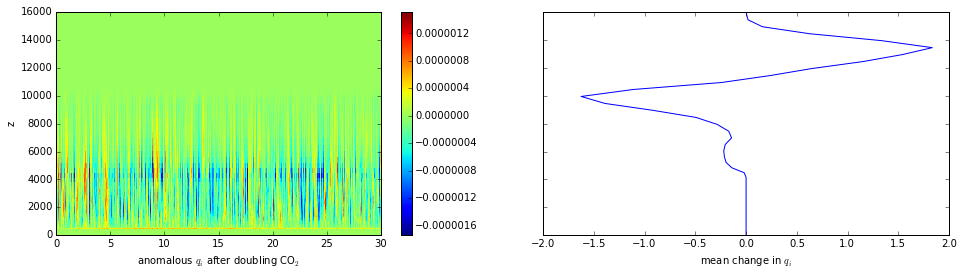

In [87]:
fig, (ax1,ax2) = plt.subplots(1, 2, sharey =True, figsize = (16,4))
im = ax1.pcolormesh(after.time, after.z, after.qc_anom.transpose())
ax1.set_ylim(0,16000)
fig.colorbar(im , ax = ax1) 
ax2.plot(1.e7*(profile(after.qi,tb = np.where(after.time>5.)[0][0])-profile(before.variables_2d['qi'], tb = np.where(before.time>-80.)[0][0])),before.z)
#ax2.plot(1.e7*climo_i,before.z)
ax2.set_xlabel('mean change in $q_i$')
ax1.set_xlabel('anomalous $q_i$ after doubling CO$_2$')
ax1.set_ylabel('z')
#fig.savefig('figures/qc_2xco2.png', bbox_inches = 0)